# Polarization of Opinion and Mood
### By Jonathan Gustafsson Frennert

### I. Dependencies

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import seaborn as sns

import math
import numpy as np
np.random.seed(42)
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

print("All packages imported!")

All packages imported!


### II. Matplotlib Parameters

In [2]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 9

In [3]:
# Latex document Text width
latex_width = 390.0

def set_size(width=latex_width, height=latex_width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    Credit to Jack Walton for the function.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    """

    fig_width_pt = width * fraction
    fig_height_pt = height * fraction
    
    inches_per_pt = 1 / 72.27
    
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## III. Color Palette

The palette is from the [iWantHue](http://medialab.github.io/iwanthue/) website by Mathieu Jacomy at the Sciences-Po Medialab.

In [4]:
colors = [
    "#ba4c40",
    "#45c097",
    "#573485",
    "#a8ae3e",
    "#8874d9",
    "#69a050",
    "#be64b2",
    "#bc7d36",
    "#5d8ad4",
    "#b94973"
]

## 1. Social Experiment Datasets

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 102

**Demographic:** Students in the department of computer science and engineering at IIT Kharagpur

**Length of Experiments:** 1 Hour

**Experiment:** Participants were presented with a topic through an online platform developed by the researchers. The platform allowed for the participants to post a message to 10 randomly assigned social neighbours (which were kept constant) and use a slider with range $[-1,1]$ ($[-10,10]$ in datasets) to represent their current stance on the topic. Each time a participant posted a message, the value of the slider and timestamp was recorded. Participants were not allowed to use the internet or communicate with others verbally.

3 datasets were collected, each with a different topic presented to the participants:
- Europe (-1) vs North America (1)
- IIT, Delhi (-1) vs IIT, Bombay (1)
- Startup (-1) vs Job (1)

Topics where chosen such that the majority of agents had no strong prior opinion, to allow for some change over time.

<center> <h3>Dataset Contents</h3> </center>

<center> <h4><code>friends.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique participant identifier $\,$ | 09CS3015 |
| `friend_ID`$\,$ | String$\,$ | Unique participant identifier for a social neighbour $\,$ | 13CS60R26 |

<center> <h4><code>messages.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique participant identifier$\,$ | 10CS30007 |
| `timestamp`$\,$ | Unix Timestamp$\,$ | Time at which participant posted an opinion$\,$ | 1379494480 |
| `opinion`$\,$ | Float $\in [-10,10]$ $\,$ | Self-reported stance towards the topic$\,$ | 1.1 |

### Questions about the data:

- What does the timestamp in the message files correspond to? Epoch time
- What was the start and end time of the experiments?
- Does every participant post a message? In the college and occupation datasets, 1 participant does not post anything. Will be considered neutral (0 in the vectors)
- Why do the friend files have 1020 rows? There are 102 participants.
- At what timestamp do we set the initial opinions? At the very first one, assume all others are 0.
- How will opinions be aggregated to timesteps? 

### 1.1 Importing

In [5]:
FRIEND_HEADERS = ['ID', 'friend_ID']
MESSAGE_HEADERS = ['ID', 'timestamp', 'opinion']

social_experiments_filepath = os.path.join(os.getcwd(), 'data', 'experiment')

continent_filepath = os.path.join(social_experiments_filepath, 'europe-vs-america')
continent_friends =  pd.read_csv(os.path.join(continent_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
continent_messages = pd.read_csv(os.path.join(continent_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

college_filepath = os.path.join(social_experiments_filepath, 'iitd-vs-iitb')
college_friends = pd.read_csv(os.path.join(college_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
college_messages = pd.read_csv(os.path.join(college_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

occupation_filepath = os.path.join(social_experiments_filepath, 'startup-vs-job')
occupation_friends = pd.read_csv(os.path.join(occupation_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
occupation_messages = pd.read_csv(os.path.join(occupation_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

### 1.2 Cleaning

- All datatypes were correctly inferred
- There were no `NaN` values in the data.

#### Removing Duplicates from Message Datasets

All the `message.txt` datasets sets had duplicate rows which were removed. 

In [6]:
continent_duplicates = continent_messages[continent_messages.duplicated()]
continent_messages = continent_messages.drop_duplicates()

print(f'No. continent duplicates: {len(continent_duplicates)}')

No. continent duplicates: 38


In [7]:
college_duplicates = college_messages[college_messages.duplicated()]
college_messages = college_messages.drop_duplicates()

print(f'No. college duplicates: {len(college_duplicates)}')

No. college duplicates: 4


In [8]:
occupation_duplicates = occupation_messages[occupation_messages.duplicated()]
occupation_messages = occupation_messages.drop_duplicates()

print(f'No. occupation duplicates: {len(occupation_duplicates)}')

No. occupation duplicates: 21


#### Removing Non-Participants

Full participation was reached for the continent experiment at 805 seconds. There is never full participation for the two other experiments, one person never participates for both. Same person with ID: **06CS3012**.

In [9]:
college_friends = college_friends[~((college_friends.ID == '06CS3012') | (college_friends.friend_ID == '06CS3012'))]
occupation_friends = occupation_friends[~((occupation_friends.ID == '06CS3012') | (occupation_friends.friend_ID == '06CS3012'))]

### 1.3 Scaling of Opinion Values

The Higham and Mantzaris network model has opinions ranged $[0,1]$, hence we must horizontally shift and compress the opinion values in the datasets. 

Trivially, we use $f(x) = \dfrac{x+10}{20}$.

In [10]:
continent_messages.opinion = (continent_messages.opinion + 10) / 20
college_messages.opinion = (college_messages.opinion + 10) / 20
occupation_messages.opinion = (occupation_messages.opinion + 10) / 20

### 1.4 Descriptive statistics

#### Europe vs North America (Continent)

In [11]:
continent_messages.describe()

,timestamp,opinion
count,2.144000e+03,2144.000000
mean,1.379496e+09,0.334841
std,8.469684e+02,0.276900
min,1.379494e+09,0.000000
25%,1.379495e+09,0.105000
50%,1.379496e+09,0.270000
75%,1.379497e+09,0.545000
max,1.379498e+09,1.000000


#### IIT, Delhi vs IIT, Bombay (College)

In [12]:
college_messages.describe()

,timestamp,opinion
count,1.754000e+03,1754.000000
mean,1.379501e+09,0.668213
std,5.720494e+02,0.268269
min,1.379500e+09,0.000000
25%,1.379500e+09,0.536250
50%,1.379500e+09,0.710000
75%,1.379501e+09,0.880000
max,1.379502e+09,1.000000


#### Startup vs Job (Occuptation)

In [13]:
occupation_messages.describe()

,timestamp,opinion
count,1.418000e+03,1418.000000
mean,1.379503e+09,0.444647
std,4.414919e+02,0.307805
min,1.379502e+09,0.000000
25%,1.379503e+09,0.161250
50%,1.379503e+09,0.402500
75%,1.379503e+09,0.703750
max,1.379504e+09,1.000000


### 1.5 Distribution of Opinions

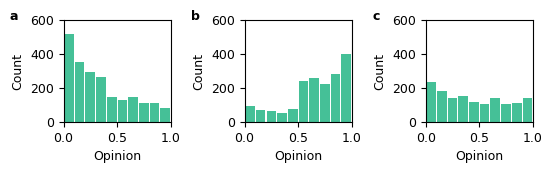

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3), height=350), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)


ax1.hist(continent_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,600)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Count')

ax2.hist(college_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,600)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Count')

ax3.hist(occupation_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,600)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Count')


ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [15]:
def outlier_cutoff(vals, q1, q3):
    """
    Essentially outlier cutoff, but clipped so that it does not go out of range
    """
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

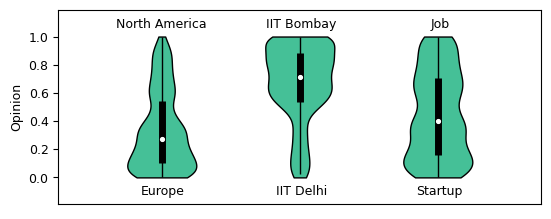

In [16]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height=150), constrained_layout=True)


data = [sorted(continent_messages.opinion), sorted(college_messages.opinion), sorted(occupation_messages.opinion)]
labels = ['Continent', 'College', 'Occupation']


plot = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
ax.set_xlim(0.25, len(labels) + 0.75)
ax.set_ylim(-0.19,1.19)
#ax.set_xticks(np.arange(1, len(labels) + 1))
#ax.set_xticklabels(labels)
ax.set_xticks([])
ax.set_ylabel('Opinion')
for pc in plot['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
Q1s = [] 
medians = [] 
Q3s = []
for xs in data:
    Q1s.append(np.percentile(xs, 25))
    medians.append(np.percentile(xs, 50))
    Q3s.append(np.percentile(xs, 75))

    
whiskers = np.array([
    outlier_cutoff(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, Q1s, Q3s)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=7.5, zorder=3)
ax.vlines(inds, Q1s, Q3s, color='black', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='black', linestyle='-', lw=1)

ax.text(0.17, 0.1, 'Europe', transform=ax.transAxes, va='top')
ax.text(0.12, 0.96, 'North America', transform=ax.transAxes, va='top')

ax.text(0.45, 0.1, 'IIT Delhi', transform=ax.transAxes, va='top')
ax.text(0.43, 0.96, 'IIT Bombay', transform=ax.transAxes, va='top')

ax.text(0.74, 0.1, 'Startup', transform=ax.transAxes, va='top')
ax.text(0.77, 0.96, 'Job', transform=ax.transAxes, va='top')

#plt.savefig('social_opinion_violinplot.pdf', format='pdf', bbox_inches='tight')
plt.show()

Distribution is a kernel density estimation of the probability density function of the opinion values.

### 1.6 Opinion Data

As we do not have access to the exact start and end times of the experiment, I see two potential ways of deciding the participants initial opinion:

1. Assume the experiment starts when the first opinion is posted. All individuals who have not posted are assumed to be neutral (0.5). The downside here is that the participant may not have had time to express their opinion, and all individuals except the first one posting will be 0.5, which seems quite unrealistic.
2. Use the last message posted by a participant or 0.5 if no post from the first timestep to set the initial opinions of each participant. This is has the downside that individuals may already be influenced by others in the first timestep. Although, this is not really an issue, any person is constantly being influenced prior to the experiment from their enviroment. This is also easier to generalize in the programming.

I choose to move forward with the second option as it will likely give a better picture of the initial opinion distribution and it suffers from much less downsides than the first option. However, one must keep in mind that if the timesteps are too small, the second option will act just like the first one.

In [17]:
continent_friends

,ID,friend_ID
0,09CS3015,13CS60R26
1,09CS3015,13CS91P03
2,09CS3015,09CS1044
3,09CS3015,07CS1034
4,09CS3015,10CS10036
...,...,...
1015,10CS30002,11CS10048
1016,10CS30002,10CS10054
1017,10CS30002,10CS10006
1018,10CS30002,13CS60R08


In [18]:
def adj_mat(friend_data):
    ids = friend_data.ID.unique()
    adj = np.zeros(shape=(len(ids),len(ids)), dtype=np.float64)
    for row in friend_data.iterrows():
        ID = row[1]['ID']
        friend_ID = row[1]['friend_ID']
        adj[np.where(ids==row[1]['ID'])[0][0],np.where(ids==row[1]['friend_ID'])[0][0]] = 1
    return ids, adj

In [19]:
def op_series(ids, msg_data, init_timestep, timestep):
    ts = []
    prtcn = []
    ops = []
    
    prev = msg_data.timestamp.min()
    cur = prev + init_timestep - 1 
    updates = msg_data[msg_data.timestamp.between(prev, cur)]
    opinions = np.full(len(ids),0.5)
    participation = np.zeros(len(ids))
    
    for i, ID in enumerate(ids):
        if ID in updates.ID.values:
            ID_updates = updates[updates.ID == ID]
            newest_idx = ID_updates.timestamp.idxmax()
            opinions[i] = ID_updates.loc[newest_idx].opinion
            participation[i] = 1
    ts.append(cur)
    prtcn.append(participation)
    ops.append(opinions)
    prev += init_timestep
    cur += init_timestep
        
    while prev <= msg_data.timestamp.max():
        updates = msg_data[msg_data.timestamp.between(prev, cur)]
        opinions = ops[-1].copy()
        participation = prtcn[-1].copy()
        for i, ID in enumerate(ids):
            if ID in updates.ID.values:
                ID_updates = updates[updates.ID == ID]
                newest_idx = ID_updates.timestamp.idxmax()
                opinions[i] = ID_updates.loc[newest_idx].opinion
                participation[i] = 1
           
        ts.append(cur)
        prtcn.append(participation)
        ops.append(opinions)
        prev += timestep
        cur += timestep
        
    return ts, list(map(lambda x: np.sum(x) / len(x), prtcn)), np.array(ops)

#### Cumulative Proportion of Participation

We will use a threshhold to determine the time use to collect the initial opinion. First we generate the opinion timeseries at the finest intervals, i.e., per second.

In [20]:
init_timestep = 1
reg_timestep = 1

continent_ids, continent_adj = adj_mat(continent_friends)
continent_ts, continent_prtcn, continent_ops = op_series(continent_ids, continent_messages, init_timestep, reg_timestep)

college_ids, college_adj =  adj_mat(college_friends)
college_ts, college_prtcn, college_ops = op_series(college_ids, college_messages, init_timestep, reg_timestep)

occupation_ids, occupation_adj =  adj_mat(occupation_friends)
occupation_ts, occupation_prtcn, occupation_ops = op_series(occupation_ids, occupation_messages, init_timestep, reg_timestep)

In [21]:
def geqidx(val, xs):
    return next((x[0] for x in enumerate(xs) if x[1] >= val), -1)

In [22]:
full_step = max(geqidx(1, college_prtcn), geqidx(1, occupation_prtcn),geqidx(1, continent_prtcn))

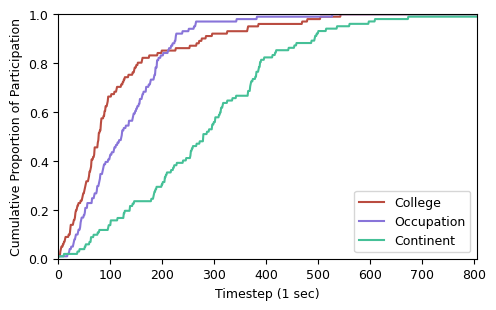

In [23]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height=latex_width * 0.6))

ax.plot(college_prtcn[:full_step], color=colors[0], label='College')
ax.plot(occupation_prtcn[:full_step], color=colors[4], label='Occupation')
ax.plot(continent_prtcn[:full_step], color=colors[1], label='Continent')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Cumulative Proportion of Participation')
ax.legend(loc='lower right')

#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [24]:
continent_lim = geqidx(1, continent_prtcn)
college_lim = geqidx(1, college_prtcn)
occupation_lim = geqidx(1, occupation_prtcn)

#### By time (full prop time)

In [25]:
def polarisation(xs):
    u = np.mean(xs)
    var = np.var(xs)
    return var / (u * (1 - u) - var)

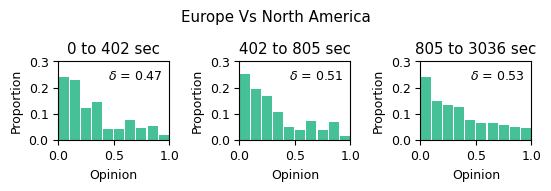

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = continent_messages.timestamp.min()
time1 = time0 + int(continent_lim / 2)
time2 = time0 + continent_lim
end = continent_messages.timestamp.max()

data1 = continent_messages[continent_messages.timestamp.between(time0, time1)].opinion
data2 = continent_messages[continent_messages.timestamp.between(time1, time2)].opinion
data3 = continent_messages[continent_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(continent_lim / 2)} sec')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(continent_lim / 2)} to {continent_lim} sec')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{continent_lim} to {len(continent_ops)} sec')

fig.suptitle('Europe Vs North America')

ax1.text(0.45, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.45, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.45, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

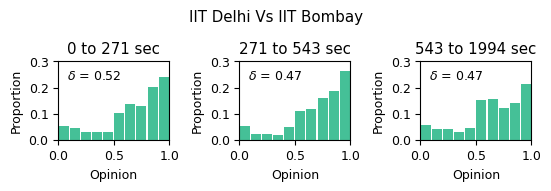

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = college_messages.timestamp.min()
time1 = time0 + int(college_lim / 2)
time2 = time0 + college_lim
end = college_messages.timestamp.max()

data1 = college_messages[college_messages.timestamp.between(time0, time1)].opinion
data2 = college_messages[college_messages.timestamp.between(time1, time2)].opinion
data3 = college_messages[college_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(college_lim / 2)} sec')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(college_lim / 2)} to {college_lim} sec')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{college_lim} to {len(college_ops)} sec')

fig.suptitle('IIT Delhi Vs IIT Bombay')

ax1.text(0.08, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.08, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.08, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

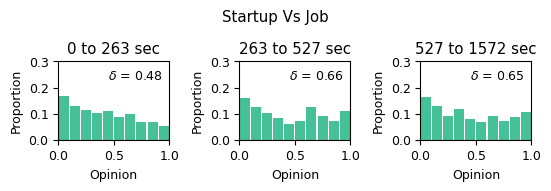

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = occupation_messages.timestamp.min()
time1 = time0 + int(occupation_lim / 2)
time2 = time0 + occupation_lim
end = occupation_messages.timestamp.max()

data1 = occupation_messages[occupation_messages.timestamp.between(time0, time1)].opinion
data2 = occupation_messages[occupation_messages.timestamp.between(time1, time2)].opinion
data3 = occupation_messages[occupation_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(occupation_lim / 2)} sec')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(occupation_lim / 2)} to {occupation_lim} sec')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{occupation_lim} to {len(occupation_ops)} sec')

fig.suptitle('Startup Vs Job')

ax1.text(0.45, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.45, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.45, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

At what proportion of participation do we have equilibrium?

How do we conclude that equilibrium has been reached?

#### By proportion

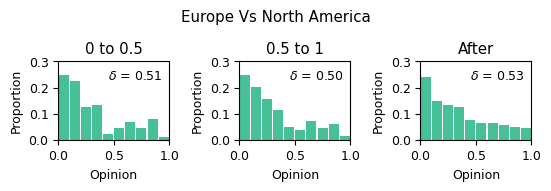

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = continent_messages.timestamp.min()
time1 = time0 + geqidx(0.5, continent_prtcn)
time2 = time0 + geqidx(1, continent_prtcn)
end = continent_messages.timestamp.max()

data1 = continent_messages[continent_messages.timestamp.between(time0, time1)].opinion
data2 = continent_messages[continent_messages.timestamp.between(time1, time2)].opinion
data3 = continent_messages[continent_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title('0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('Europe Vs North America')

ax1.text(0.45, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.45, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.45, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')

#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

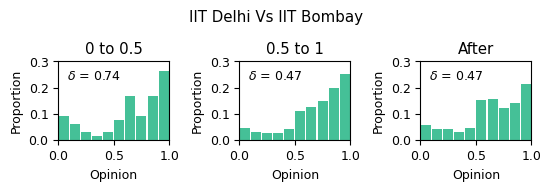

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = college_messages.timestamp.min()
time1 = time0 + geqidx(0.5, college_prtcn)
time2 = time0 + geqidx(101/102, college_prtcn)
end = college_messages.timestamp.max()

data1 = college_messages[college_messages.timestamp.between(time0, time1)].opinion
data2 = college_messages[college_messages.timestamp.between(time1, time2)].opinion
data3 = college_messages[college_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('IIT Delhi Vs IIT Bombay')

ax1.text(0.08, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.08, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.08, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')

#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

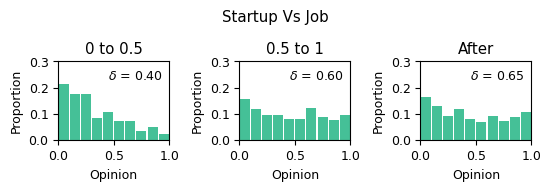

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = occupation_messages.timestamp.min()
time1 = time0 + geqidx(0.5, occupation_prtcn)
time2 = time0 + geqidx(101/102, occupation_prtcn)
end = occupation_messages.timestamp.max()

data1 = occupation_messages[occupation_messages.timestamp.between(time0, time1)].opinion
data2 = occupation_messages[occupation_messages.timestamp.between(time1, time2)].opinion
data3 = occupation_messages[occupation_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title('0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('Startup Vs Job')

ax1.text(0.45, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.45, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.45, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

Consensus is already reached when half the participants have expressed their opinion.


Cumulative percentage who have talked
-> Can be used to decide initial collecting time
- Determine if converge is really happening or just how we set opinions? take snapshot from seconds before limit is reached and after, is there a significant different in distribution of opinions? we can conclude its fine to start from total distribution, but we should find out when equilibrium has not been reached yet, quite early. By 0.5 participation, bit of a problem, cuz we want full participation.


### 1.7 Visualising Opinion Time Series

I tried computing the waterfall plot, however, as peoples opinions change so much, it does not look very continous. I also tried visualising the networks, however, they were too dense to find anything interesting. I did have success by recording the mean opinion value at each time step. There seems to be a convergence within the first ~8.3 minutes (500 seconds), where for all the experiments, the mean opinion value have lost there monotonous behaviour. 

Theta can be calculated from mean opinion plot, but can it be done mathematically?

The normal distribution of the opinions means after stability point is false.

We use highest possible participation to create the initial opinion series.

In [32]:
continent_ts = continent_ts[continent_lim:]
continent_prctn = continent_prtcn[continent_lim:] 
continent_ops = continent_ops[continent_lim:]

college_ts = college_ts[college_lim:]
college_prctn = college_prtcn[college_lim:] 
college_ops = college_ops[college_lim:]

occupation_ts = occupation_ts[occupation_lim:]
occupation_prctn = occupation_prtcn[occupation_lim:] 
occupation_ops = occupation_ops[occupation_lim:]

In [33]:
def means(xs):
    means = []
    for x in xs:
        means.append(np.mean(x))
    return means

In [34]:
continent_ops_means = means(continent_ops)
college_ops_means = means(college_ops)
occupation_ops_means = means(occupation_ops)

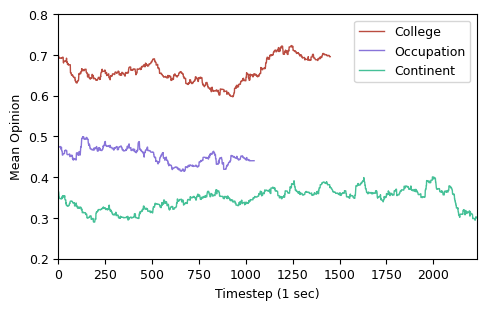

In [35]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(college_ops_means, linewidth=1, color=colors[0], label='College')
ax.plot(occupation_ops_means, linewidth=1.0,color=colors[4], label='Occupation')
ax.plot(continent_ops_means, linewidth=1.0,color=colors[1], label='Continent')
ax.margins(x=0)
ax.set_ylim(0.2,0.8)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Mean Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

Here, we see further that consensus is reached when full participation in initial opinion component.

In [36]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### 1.8 Comparing a participant with their neighbours

In [37]:
def get_friends(ID, friends):
    return friends[friends.ID == ID].friend_ID

In [38]:
def get_idx(ids, ID):
    return np.where(ids == ID)[0][0]

In [39]:
def friend_analysis(ids, adj, ops):
    idx_result = []
    dist_result = []
    corr_result = []

    for idx, ID in enumerate(ids):
        friend_data = [ ops[:, get_idx(ids, friend)] for friend in ids[adj[get_idx(ids, ID)].astype(bool)]]
        mean_friend_data = means(np.transpose(friend_data))
        id_data = ops[:, idx]
        dist = np.abs(id_data[0] - 0.5)
        friend_corr = np.corrcoef(id_data, mean_friend_data)[0, 1]
        
        # We ignore nan
        if not math.isnan(friend_corr):
            idx_result.append(idx)
            dist_result.append(dist)
            corr_result.append(friend_corr)
    
    return idx_result, dist_result, corr_result

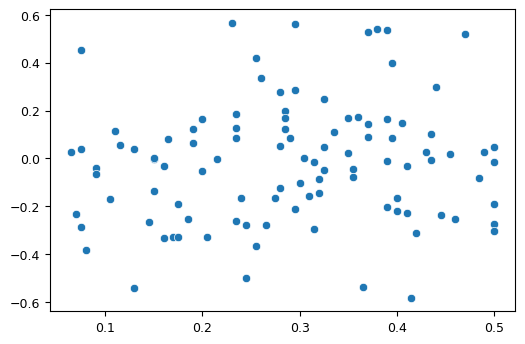

In [40]:
a, b, c = friend_analysis(continent_ids, continent_adj, continent_ops)

sns.scatterplot(b, c)

plt.show()

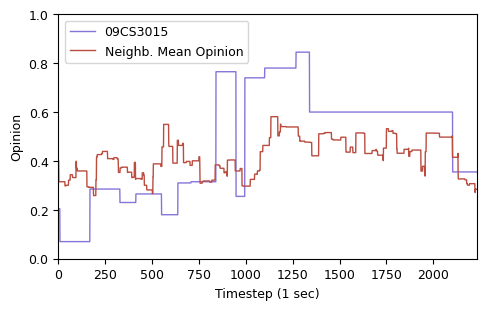

In [41]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

labels = get_friends('09CS3015', continent_friends)
data = [ continent_ops[:, get_idx(continent_ids, friend)] for friend in labels]
id_data = continent_ops[:, get_idx(continent_ids,'09CS3015')]
mean_data = means(np.transpose(data))

ax.plot(id_data, linewidth=1.0,color=colors[4], label='09CS3015')
ax.plot(mean_data, linewidth=1.0, color=colors[0], label='Neighb. Mean Opinion')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 1.9 Further analysis functions

In [42]:
def diff_series(ops):
    result = []
    
    prev = ops[0]
    for i in range(1, len(ops)):
        cur = ops[i]
        result.append(np.sign(cur - prev))
        prev = cur
        
    return result

In [43]:
def decisions(id_decs, ne_decs):
    id_res = []
    ne_res = []
    
    for i in range(len(id_decs)):
        if id_decs[i] != 0:
            id_res.append(id_decs[i])
            
            added = False
            for dec in ne_decs[:i+1][::-1]:
                if dec != 0:
                    ne_res.append(dec)
                    added = True
                    break
            
            if not added:
                ne_res.append(0)
    
    return id_res, ne_res    

In [44]:
def friend_dec_analysis(ids, adj, ops):
    idx_result = []
    corr_result = []
    for idx, ID in enumerate(ids):
        friend_data = [ ops[:, get_idx(ids, friend)] for friend in ids[adj[get_idx(ids, ID)].astype(bool)]]
        mean_friend_data = diff_series(means(np.transpose(friend_data)))
        id_data = diff_series(ops[:, idx])
        id_decs, friend_decs = decisions(id_data, mean_friend_data) 
        corr = np.corrcoef(id_decs, friend_decs)[0, 1]
        
        # We ignore nan
        if not math.isnan(corr):
            idx_result.append(idx)
            corr_result.append(corr)
    
    return idx_result, corr_result

In [45]:
def ne_diff_series(ops, ne_ops):
    result = []
    
    prev = np.abs(ne_ops[0] - ops[0])
    for i in range(1, len(ops)):
        cur = np.abs(ne_ops[i] - ops[i])
        if ops[i-1] != ops[i]:
            res = np.sign(prev - cur)
            result.append(res)
        prev = cur
        
    return result

In [46]:
def friend_ne_dec_analysis(ids, adj, ops):
    idx_result = []
    dec_result = []
    for idx, ID in enumerate(ids):
        friend_data = [ ops[:, get_idx(ids, friend)] for friend in ids[adj[get_idx(ids, ID)].astype(bool)]]
        mean_ne_data = means(np.transpose(friend_data))
        ne_diff_data = ne_diff_series(ops[:, idx], mean_ne_data)
        corr_res = np.corrcoef(ne_diff_data, range(len(ne_diff_data)))[0,1]
        
        if not math.isnan(corr_res):
            idx_result.append(idx)
            dec_result.append(np.corrcoef(ne_diff_data, range(len(ne_diff_data)))[0,1])
        
    return idx_result, dec_result

### 1.10 Correlation of decisions with neighbours

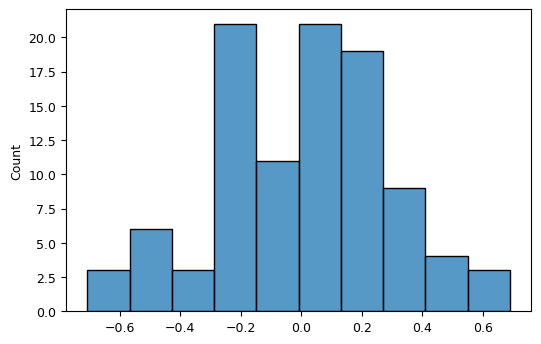

In [47]:
idx_data, dec_data = friend_dec_analysis(continent_ids, continent_adj, continent_ops)
sns.histplot(dec_data)
plt.show()

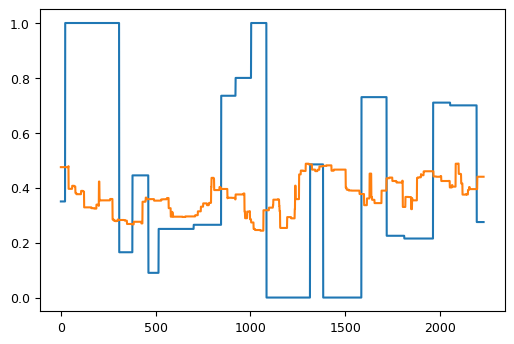

In [48]:
labels = get_friends(continent_ids[60], continent_friends)
data = [ continent_ops[:, get_idx(continent_ids, friend)] for friend in labels]
id_data = continent_ops[:, 60]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), id_data)
sns.lineplot(range(len(id_data)), mean_data)
plt.show()

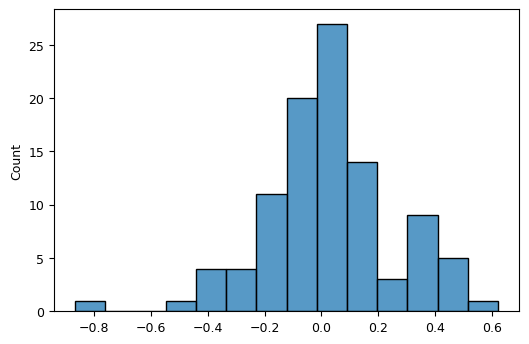

In [49]:
idx_result, dec_data = friend_ne_dec_analysis(continent_ids, continent_adj, continent_ops)
sns.histplot(dec_data)
plt.show()

In [50]:
np.mean(dec_data)

0.021548610249958074

### 1.11 Decrease in difference with neighbours opinion over time?

In [51]:
def friend_diff_analysis(ids, adj, ops):
    idx_result = []
    corr_result = []
    time_data = range(len(ops))
    for idx, ID in enumerate(ids):
        friend_data = [ ops[:, get_idx(ids, friend)] for friend in ids[adj[get_idx(ids, ID)].astype(bool)]]
        mean_friend_data = means(np.transpose(friend_data))
        id_data = ops[:, idx]
        diff_data = np.abs(mean_friend_data - id_data)
        corr = np.corrcoef(time_data, diff_data)[0, 1]
        
        # We ignore nan
        if not math.isnan(corr):
            idx_result.append(idx)
            corr_result.append(corr)
    
    return idx_result, corr_result

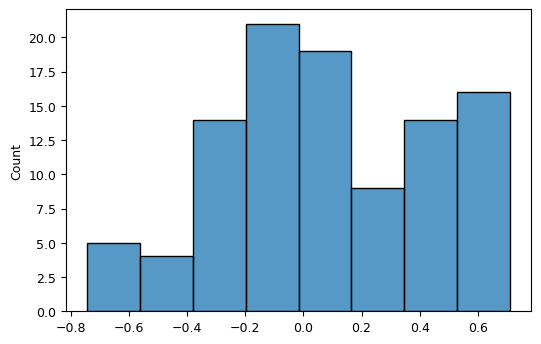

In [52]:
idx_data, diff_data = friend_diff_analysis(continent_ids, continent_adj, continent_ops)
sns.histplot(diff_data)
plt.show()

An interesting distribution, considering all other datasets had a normal distribution.

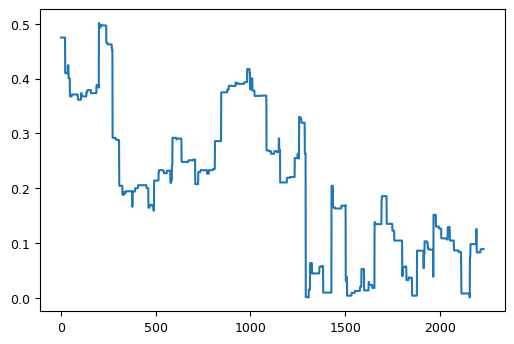

In [53]:
labels = get_friends(continent_ids[46], continent_friends)
data = [ continent_ops[:, get_idx(continent_ids, friend)] for friend in labels]
id_data = continent_ops[:, 46]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), np.abs(np.array(mean_data) - id_data))
plt.show()

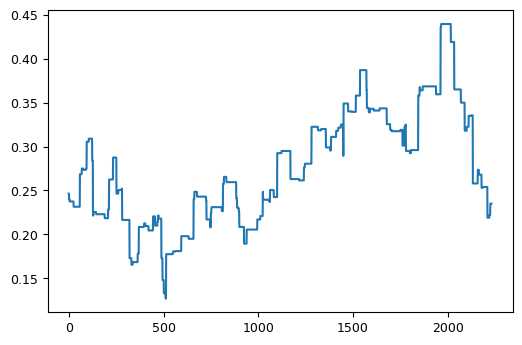

In [54]:
labels = get_friends(continent_ids[67], continent_friends)
data = [ continent_ops[:, get_idx(continent_ids, friend)] for friend in labels]
id_data = continent_ops[:, 67]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), np.abs(np.array(mean_data) - id_data))
plt.show()

Some people listen, others don't, can't say more than that.

### 1.12 Transition of opinion valences

In [55]:
counts = np.zeros(4)


for op in np.transpose(continent_ops):
    if op[0] < 0.5 and op[-1] < 0.5:
        counts[0] += 1
    elif op[0] < 0.5 and op[-1] > 0.5:
        counts[1] += 1
    elif op[0] > 0.5 and op[-1] < 0.5:
        counts[2] += 1
    if op[0] > 0.5 and op[-1] > 0.5:
        counts[3] += 1
        
print(counts / 102)

[0.62745098 0.04901961 0.14705882 0.17647059]


In [56]:
counts = np.zeros(4)


for op in np.transpose(college_ops):
    if op[0] < 0.5 and op[-1] < 0.5:
        counts[0] += 1
    elif op[0] < 0.5 and op[-1] > 0.5:
        counts[1] += 1
    elif op[0] > 0.5 and op[-1] < 0.5:
        counts[2] += 1
    if op[0] > 0.5 and op[-1] > 0.5:
        counts[3] += 1
        
print(counts / 101)

[0.08910891 0.06930693 0.07920792 0.76237624]


In [57]:
counts = np.zeros(4)


for op in np.transpose(occupation_ops):
    if op[0] < 0.5 and op[-1] < 0.5:
        counts[0] += 1
    elif op[0] < 0.5 and op[-1] > 0.5:
        counts[1] += 1
    elif op[0] > 0.5 and op[-1] < 0.5:
        counts[2] += 1
    if op[0] > 0.5 and op[-1] > 0.5:
        counts[3] += 1
        
print(counts / 101)

[0.41584158 0.0990099  0.17821782 0.30693069]


## 2. Twitter Dataset

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 548*; largest single connected component from the follow network constructed after filtering out corporate, bot and spammer accounts. 

**Demographic:** Anybody using the #BJP, #APP, #Congress, and #Polls2013 hashtags in tweets between the 9th and 15th December 2013. 

Look deeper into the characterisation of political orientation of Indian twitter users, and potential ramifications for our results.

**Dates on which tweets where collected:** 9th to 15th December 2013. The week after the results for the Delhi assembly election on the 8th December 2013.

**Explanation:** All tweets between the 9th and 15th December containing the hashtags #BJP, #APP, #Congress, and #Polls2013 were collected. This was the week after the results for the 2013 Delhi assembly election were released. The three first hashtags correspond to the three parties involved in the election, whilst the last hashtag is the one most strongly associated with the event. As the parties had recieved roughly equal votes, they needed to create a post-poll alliance for majority ruling, this led to many expressing their opinions on Twitter. To begin with ~905,000 tweets by ~201,000 users were collected. The users were then filtered for having between 100 and 10,000 friends; between 50 and 1,000 followers; and between 200 and 10,000 tweets. This was to remove corporate, bot and spammer accounts. The number of eligible users was ~55,000. By collecting the user IDs of all the followees and followers of these users, a follow network was constructed. Finally, the network studied is the largest single connected component where each user had posted over 20 tweets from the follow network. The opinion values were created hourly by taking the tweets of each user in that hour and adding it to a text document (no opinion if no tweets in that hour). These documents were then transformed to opinion scores $[-1,1]$ representing the attitude towards the political developments of the election. Specifically, the score represent the relative proportion of positive to negative connotative words in the document.

`* Filtering down from ~201,000 users.`

**Sentiment Analysis Tool:** A. Hannak, E. Anderson, L. F. Barrett, S. Lehmann,
A. Mislove, and M. Riedewald. Tweetin’ in the Rain:
Exploring societal-scale effects of weather on mood. In
*Proceedings of the 6th International AAAI Conference on
Weblogs and Social Media (ICWSM ’12)*, Dublin, Ireland,
June 2012.

#### Critique

- The sentiment analysis tool was initially intended for studying weather.
- The negative and positive connotations are associated with a small set of emoticons.
- How well does positive and negative connotation align a political axis in this situation? Often the difference between political parties is what they have negative and positive associations with, not that they are just negative or positive.


<center> <h3>Dataset Contents</h3> </center>

<center> <h4><code>nodelist.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique user identifier $\,$ | 7954422 |

<center> <h4><code>edgelist.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique user identifier $\,$ | 120373248 |
| `friend_ID`$\,$ | String$\,$ | Unique user identifier for a followee $\,$ | 108939299 |



<center> <h4><code>opinion.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique user identifier$\,$ | 69539409 |
| `timestamp`$\,$ | Unix Timestamp$\,$ | Hour at which user has tweeted$\,$ | 1386626400 |
| `opinion`$\,$ | Float $\in (-6.5,4.6)$ $\,$ | Aggregate sentiment analysis of all tweets by the user in the previous hour $\,$ | -0.544628526943 |

### Questions about the data:

- Is the `friend_ID` a follower or followee? Followee by principle of the social experiment datasets

### 2.1 Importing

In [58]:
NODE_HEADERS = ['ID']
EDGE_HEADERS = ['ID', 'friend_ID']
OPINION_HEADERS = ['ID', 'timestamp', 'opinion']

social_media_filepath = os.path.join(os.getcwd(), 'data', 'media')

twitter_filepath = os.path.join(social_media_filepath, 'twitter')
twitter_nodes =  pd.read_csv(os.path.join(twitter_filepath, 'nodelist.txt'), sep= ' ', header = None, names = NODE_HEADERS)
twitter_edges = pd.read_csv(os.path.join(twitter_filepath, 'edgelist.txt'), sep= ' ', header = None, names = EDGE_HEADERS)
twitter_opinions = pd.read_csv(os.path.join(twitter_filepath, 'opinion.txt'), sep= ' ', header = None, names = OPINION_HEADERS)

### 2.2 Cleaning

- There were no duplicates
- No NaN values or outliers

#### Correcting Inferred Variable Types

All ID fields have been incorrectly inferred to `int64` when they should be `object` types.

In [59]:
twitter_nodes.ID = twitter_nodes.ID.astype(str)
twitter_edges.ID = twitter_edges.ID.astype(str)
twitter_edges.friend_ID = twitter_edges.friend_ID.astype(str)
twitter_opinions.ID = twitter_opinions.ID.astype(str)

### 2.3 Scaling of Opinion Values

The Higham and Mantzaris network model has opinions ranged $[0,1]$ 

Trivially, we use $f(x) = \dfrac{x-x_{min}}{x_{max} - x_{min}}$.

Where $x_{min} = -6.48366001409$ and $x_{max} = 4.52493159834$.

In [60]:
twitter_opinions.opinion = (twitter_opinions.opinion - twitter_opinions.opinion.min()) / (twitter_opinions.opinion.max() - twitter_opinions.opinion.min())

### 2.4 Descriptive statistics

In [61]:
twitter_opinions.describe()

,timestamp,opinion
count,2.002600e+04,20026.000000
mean,1.386946e+09,0.595805
std,1.834926e+05,0.073758
min,1.386626e+09,0.000000
25%,1.386781e+09,0.558538
50%,1.386943e+09,0.599646
75%,1.387098e+09,0.638738
max,1.387282e+09,1.000000


### 2.5 Distribution of Opinions

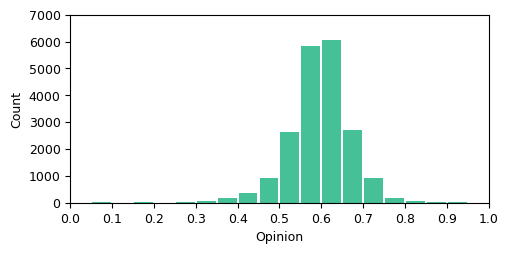

In [62]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = 180))

bins = np.arange(0,1.05,0.05)
ticks = np.arange(0,1.05,0.1)


ax.hist(twitter_opinions.opinion, bins, rwidth=0.9, color=colors[1])
ax.set_xlim(0,1)
ax.set_xticks(ticks)
ax.margins(x=0)
ax.set_ylim(0,7000)
ax.set_xlabel('Opinion')
ax.set_ylabel('Count')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2.6 Opinion Data

In [63]:
init_timestep = 3600
reg_timestep = 3600

twitter_ids, twitter_adj = adj_mat(twitter_edges)
twitter_ts, twitter_prtcn, twitter_ops = op_series(twitter_ids, twitter_opinions, init_timestep, reg_timestep)

### 2.7 Cumulative proportion of participation

In [64]:
twitter_lim = geqidx(1, twitter_prtcn)

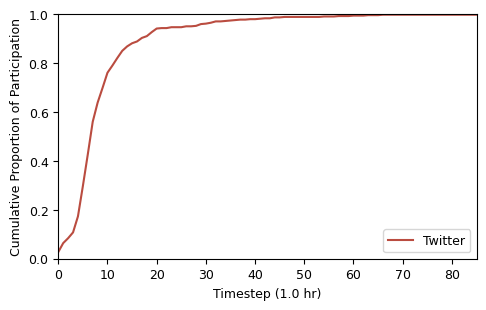

In [65]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height=latex_width * 0.6))

ax.plot(twitter_prtcn[:twitter_lim], color=colors[0], label='Twitter')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep / 3600} hr)')
ax.set_ylabel('Cumulative Proportion of Participation')
ax.legend(loc='lower right')

#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

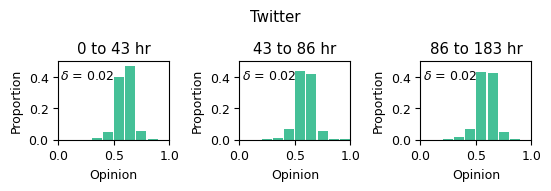

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = twitter_opinions.timestamp.min()
time1 = time0 + int(twitter_lim * 3600 / 2)
time2 = time0 + twitter_lim * 3600
end = twitter_opinions.timestamp.max()

data1 = twitter_opinions[twitter_opinions.timestamp.between(time0, time1)].opinion
data2 = twitter_opinions[twitter_opinions.timestamp.between(time1, time2)].opinion
data3 = twitter_opinions[twitter_opinions.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.5)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(twitter_lim / 2)} hr')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.5)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(twitter_lim / 2)} to {twitter_lim} hr')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.5)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{twitter_lim} to {len(twitter_ops)} hr')

fig.suptitle('Twitter')

ax1.text(0.02, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.02, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.02, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')

#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

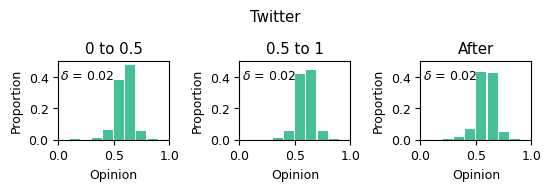

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = twitter_opinions.timestamp.min()
time1 = time0 + geqidx(0.5, twitter_prtcn) * 3600
time2 = time0 + geqidx(1, twitter_prtcn) * 3600
end = twitter_opinions.timestamp.max()

data1 = twitter_opinions[twitter_opinions.timestamp.between(time0, time1)].opinion
data2 = twitter_opinions[twitter_opinions.timestamp.between(time1, time2)].opinion
data3 = twitter_opinions[twitter_opinions.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.5)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title('0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.5)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.5)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('Twitter')

ax1.text(0.02, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.02, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.02, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')

#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2.8 Visualising Opinion Timeseries

In [68]:
twitter_ops_means = means(twitter_ops)

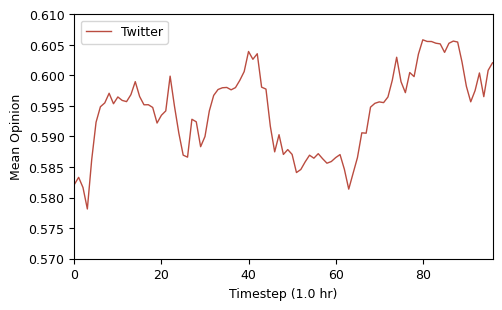

In [69]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(twitter_ops_means[twitter_lim:], linewidth=1, color=colors[0], label='Twitter')
ax.margins(x=0)
ax.set_ylim(0.57,0.61)
ax.set_xlabel(f'Timestep ({reg_timestep / 3600} hr)')
ax.set_ylabel('Mean Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2.9 Impact of neighbours 

In [70]:
twitter_ts = twitter_ts[twitter_lim:]
twitter_prctn = twitter_prtcn[twitter_lim:] 
twitter_ops = twitter_ops[twitter_lim:]

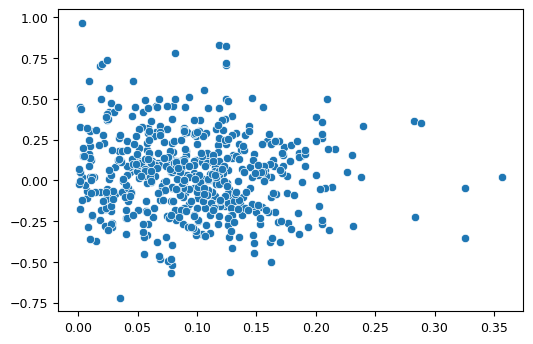

In [71]:
a, b, c = friend_analysis(twitter_ids, twitter_adj, twitter_ops)

sns.scatterplot(b, c)

plt.show()

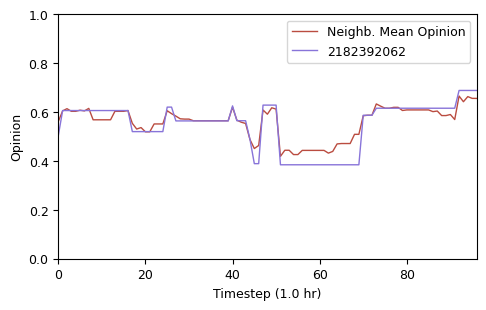

In [72]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

labels = get_friends('2182392062', twitter_edges)
data = [ twitter_ops[:, get_idx(twitter_ids, friend)] for friend in labels]
mean_data = means(np.transpose(data))


ax.plot(mean_data, linewidth=1.0, color=colors[0], label='Neighb. Mean Opinion')
ax.plot(twitter_ops[:, get_idx(twitter_ids,'2182392062')], linewidth=1.0,color=colors[4], label='2182392062')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep / 3600} hr)')
ax.set_ylabel('Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

Someones copying others tweets it would seem.

### 2.10 Number of neighbours and correlation of opinion with neighbours

In [73]:
np.corrcoef(np.log(np.sum(twitter_adj, axis=1)), c)[0,1]

0.133180914354411

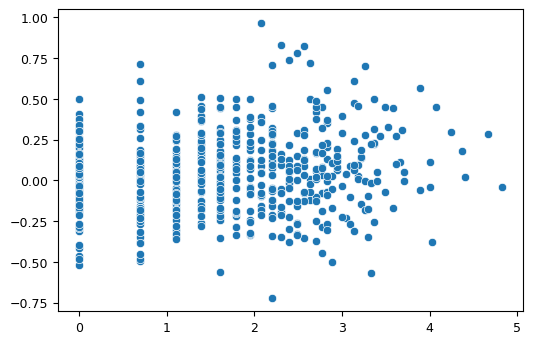

In [74]:
sns.scatterplot(np.log(np.sum(twitter_adj, axis=1)), c)

plt.show()

### 2.11 Difference in opinions with neighbours

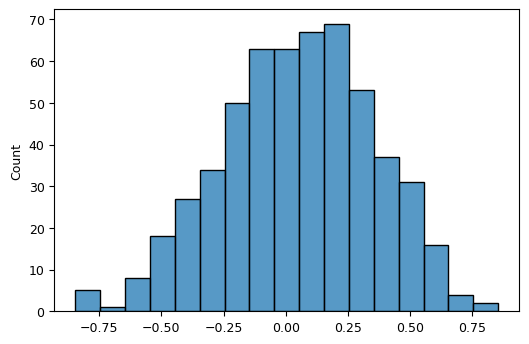

In [75]:
idx_data, diff_data = friend_diff_analysis(twitter_ids, twitter_adj, twitter_ops)
sns.histplot(diff_data)
plt.show()

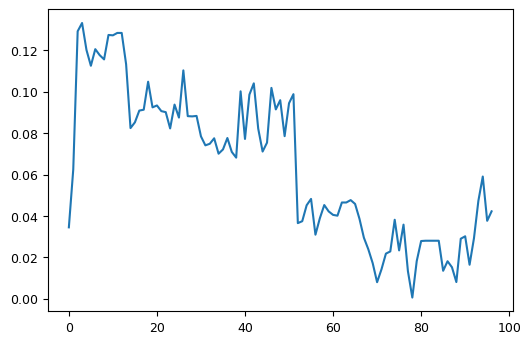

In [76]:
labels = get_friends(twitter_ids[114], twitter_edges)
data = [ twitter_ops[:, get_idx(twitter_ids, friend)] for friend in labels]
id_data = twitter_ops[:, 114]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), np.abs(np.array(mean_data) - id_data))
plt.show()

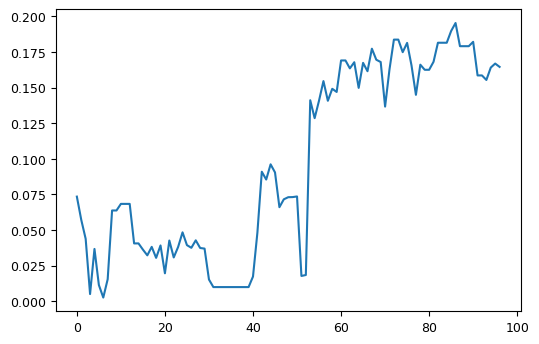

In [77]:
labels = get_friends(twitter_ids[208], twitter_edges)
data = [ twitter_ops[:, get_idx(twitter_ids, friend)] for friend in labels]
id_data = twitter_ops[:, 208]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), np.abs(np.array(mean_data) - id_data))
plt.show()

The contrarian is like the opposite of the listener, different scale, keep in mind.

### 2.12 Correlation of decisions with neighbours

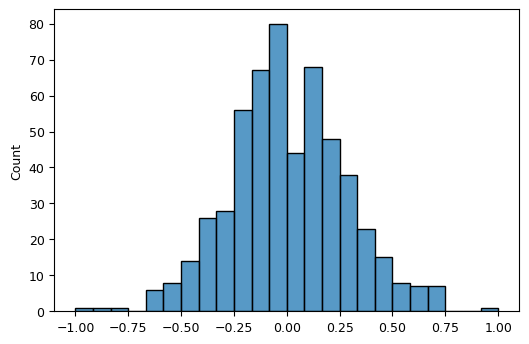

In [78]:
idx_data, dec_data = friend_dec_analysis(twitter_ids, twitter_adj, twitter_ops)
sns.histplot(dec_data)
plt.show()

Positive outlier is bot shown above.

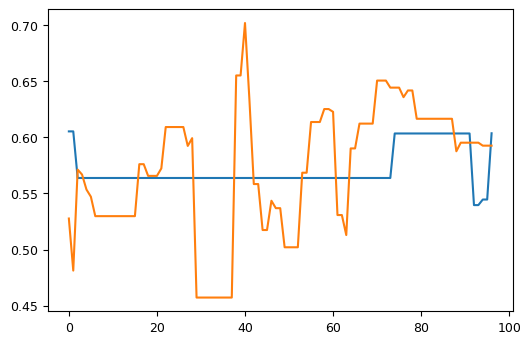

In [79]:
labels = get_friends(twitter_ids[465], twitter_edges)
data = [ twitter_ops[:, get_idx(twitter_ids, friend)] for friend in labels]
id_data = twitter_ops[:, 465]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), id_data)
sns.lineplot(range(len(id_data)), mean_data)
plt.show()

## 3. Reddit Dataset

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 556*

**Demographic:** Anybody who posted in the 'politics' subreddit between July 1 and December 31, 2012.

Look deeper into the characterisation of political orientation of Reddit Politics users, and potential ramifications for our results.

**Dates on which tweets where collected:** July 1 to December 31, 2012.

**Explanation:** All users who posted on the 'politics' subreddit between July 1 and December 31, 2012 were recorded. This resulted in ~31,000 users, from which a undirected user network was created, in which an edge means that the two users posted in two of the same subreddits in the given time period (excluding politics). The ~500 users were randomly selected such that they formed a single connected component where each user had over 20 submissions in the given time period. In contrast to the Twitter data, given that there is no character restrictions, most posts are made with well-formed english. This led to the use of the LIWC to calculate the opinion score. The opinion score of each post was equal to the normalised difference between the positive emotion score and the negative emotion score, where normalisation was mapping the range of values to $[-1,1]$ using linear scaling.

**Sentiment Analysis Tool:** J. W. Pennebaker, M. E. Francis, and R. J. Booth. LIWC:
Linguistic Inquiry and Word Count. liwc.net, 2007.
Accessed on June 03, 2014.

`* Filtering down from ~31,000 users.`

- Are people really friends / contacts if they post in the two same subreddits over a 6 month period?
- Most posts go unnoticed, how do we know that the users saw each others posts?
- Similar questions with sentiment analysis as for Twitter data

<center> <h3>Dataset Contents</h3> </center>

<center> <h4><code>nodelist.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique user identifier $\,$ | 19457 |

<center> <h4><code>edgelist.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique user identifier $\,$ | 13 |
| `friend_ID`$\,$ | String$\,$ | Unique user identifier for a followee $\,$ | 5083 |


<center> <h4><code>edgex.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `IDX`$\,$ | String $\,$ | index of ID $\,$ | 11 |
| `friend_IDX`$\,$ | String $\,$ | index of ID $\,$ | 1 |


<center> <h4><code>opinion.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `id`$\,$ | String$\,$ | Unique user identifier$\,$ | 13 |
| `???`$\,$ | $\,$ | Just Ignore $\,$ | 58092647 |
| `timestamp`$\,$ | Unix Timestamp$\,$ | Time at which user posted$\,$ | 1345566466 |
| `opinion`$\,$ | Float $\in [-100,100]$ $\,$ | Sentiment analysis of post $\,$ | -15.38 |

### Questions about the data:

- Is the `friend_ID` a follower or followee? Followee by principle of the social experiment datasets

### 3.1 Importing

In [80]:
EDGEX_HEADERS = ['na1', 'na2']
OPINION_HEADERS = ['ID', 'na', 'timestamp', 'opinion']

social_media_filepath = os.path.join(os.getcwd(), 'data', 'media')

reddit_filepath = os.path.join(social_media_filepath, 'reddit')
reddit_nodes =  pd.read_csv(os.path.join(reddit_filepath, 'nodelist.txt'), sep= ' ', header = None, names = NODE_HEADERS)
reddit_edges = pd.read_csv(os.path.join(reddit_filepath, 'edgelist.txt'), sep= ' ', header = None, names = EDGE_HEADERS)
reddit_edgex = pd.read_csv(os.path.join(reddit_filepath, 'edgex.txt'), sep= ' ', header = None, names = EDGEX_HEADERS)
reddit_opinions = pd.read_csv(os.path.join(reddit_filepath, 'opinion.txt'), sep= ' ', header = None, names = OPINION_HEADERS)

### 3.2 Cleaning

- There were no duplicates
- No NaN values or outliers

#### Remove Unnecessary Columns

In [81]:
reddit_opinions = reddit_opinions.drop('na', axis=1)

#### Correcting Inferred Variable Types

All ID fields have been incorrectly inferred to `int64` when they should be `object` types.

In [82]:
reddit_nodes.ID = reddit_nodes.ID.astype(str)
reddit_edges.ID = reddit_edges.ID.astype(str)
reddit_edges.friend_ID = reddit_edges.friend_ID.astype(str)
reddit_opinions.ID = reddit_opinions.ID.astype(str)

### 3.3 Scaling of Opinion Values

The Higham and Mantzaris network model has opinions ranged $[0,1]$ 

Trivially, we use $f(x) = \dfrac{x-x_{min}}{x_{max} - x_{min}}$.

Where $x_{min} = -100$ and $x_{max} = 100$.

In [83]:
reddit_opinions.opinion = (reddit_opinions.opinion + 100) / 200

### 3.4 Descriptive statistics

In [84]:
reddit_opinions.describe()

,timestamp,opinion
count,6.436600e+04,64366.000000
mean,1.349085e+09,0.497456
std,4.112776e+06,0.040266
min,1.341101e+09,0.000000
25%,1.345740e+09,0.489350
50%,1.349196e+09,0.500000
75%,1.352266e+09,0.500000
max,1.356998e+09,1.000000


### 3.5 Distribution of Opinions

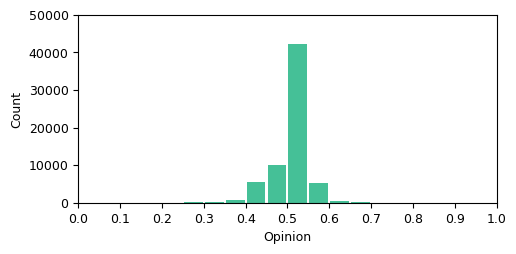

In [85]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = 180))

bins = np.arange(0,1.05,0.05)
ticks = np.arange(0,1.05,0.1)


ax.hist(reddit_opinions.opinion,bins, rwidth=0.9, color=colors[1])
ax.set_xlim(0,1)
ax.set_xticks(ticks)
ax.margins(x=0)
ax.set_ylim(0, 50000)
ax.set_xlabel('Opinion')
ax.set_ylabel('Count')



#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 3.6 Opinion Data

In [86]:
reddit_ids = np.array(list(set(reddit_edges.ID.unique()).union(reddit_edges.friend_ID.unique())))
reddit_adj = np.zeros(shape=(len(reddit_ids), len(reddit_ids)), dtype=np.float64)
for row in reddit_edges.iterrows():
    ID = row[1]['ID']
    friend_ID = row[1]['friend_ID']
    idx = np.where(reddit_ids == ID)
    friend_idx = np.where(reddit_ids == friend_ID)
    reddit_adj[idx,friend_idx] = 1
    reddit_adj[friend_idx, idx] = 1

In [87]:
init_timestep = 3600
reg_timestep = 3600

reddit_ts, reddit_prtcn, reddit_ops = op_series(reddit_ids, reddit_opinions, init_timestep, reg_timestep)

### 3.7 Cumulative proportion of participation

In [88]:
reddit_lim = geqidx(1, reddit_prtcn)

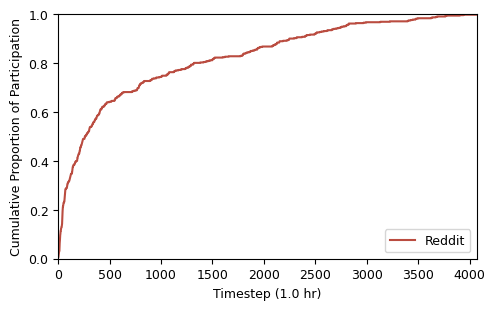

In [89]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height=latex_width * 0.6))

ax.plot(reddit_prtcn[:reddit_lim], color=colors[0], label='Reddit')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep / 3600} hr)')
ax.set_ylabel('Cumulative Proportion of Participation')
ax.legend(loc='lower right')

#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

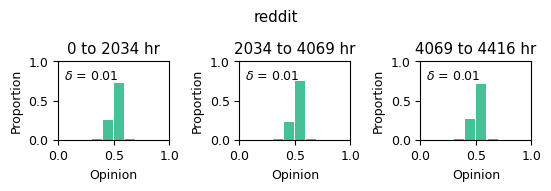

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = reddit_opinions.timestamp.min()
time1 = time0 + int(reddit_lim * 3600 / 2)
time2 = time0 + reddit_lim * 3600
end = reddit_opinions.timestamp.max()

data1 = reddit_opinions[reddit_opinions.timestamp.between(time0, time1)].opinion
data2 = reddit_opinions[reddit_opinions.timestamp.between(time1, time2)].opinion
data3 = reddit_opinions[reddit_opinions.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,1)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(reddit_lim / 2)} hr')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(reddit_lim / 2)} to {reddit_lim} hr')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{reddit_lim} to {len(reddit_ops)} hr')

fig.suptitle('reddit')

ax1.text(0.05, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.05, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.05, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')

#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

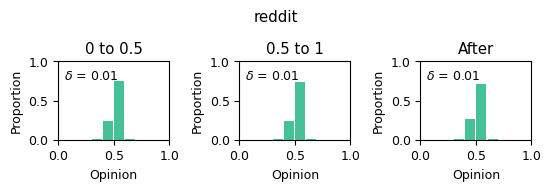

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = reddit_opinions.timestamp.min()
time1 = time0 + geqidx(0.5, reddit_prtcn) * 3600
time2 = time0 + geqidx(1, reddit_prtcn) * 3600
end = reddit_opinions.timestamp.max()

data1 = reddit_opinions[reddit_opinions.timestamp.between(time0, time1)].opinion
data2 = reddit_opinions[reddit_opinions.timestamp.between(time1, time2)].opinion
data3 = reddit_opinions[reddit_opinions.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,1)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title('0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('reddit')

ax1.text(0.05, 0.9, f'$\delta$ = {polarisation(data1):.2f}', transform=ax1.transAxes, va='top')
ax2.text(0.05, 0.9, f'$\delta$ = {polarisation(data2):.2f}', transform=ax2.transAxes, va='top')
ax3.text(0.05, 0.9, f'$\delta$ = {polarisation(data3):.2f}', transform=ax3.transAxes, va='top')

#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 3.8 Visualising Opinion Timeseries

In [92]:
reddit_ops_means = means(reddit_ops)

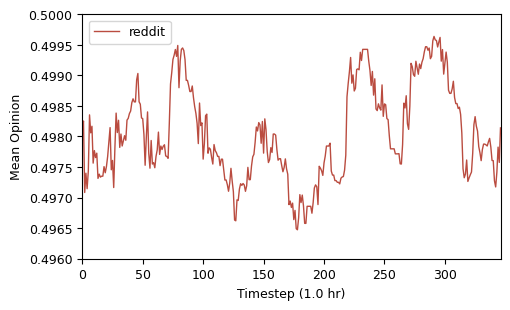

In [93]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(reddit_ops_means[reddit_lim:], linewidth=1, color=colors[0], label='reddit')
ax.margins(x=0)
ax.set_ylim(0.496,0.5)
ax.set_xlabel(f'Timestep ({reg_timestep / 3600} hr)')
ax.set_ylabel('Mean Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 3.9 Impact of neighbours 

In [94]:
reddit_ts = reddit_ts[reddit_lim:]
reddit_prctn = reddit_prtcn[reddit_lim:] 
reddit_ops = reddit_ops[reddit_lim:]

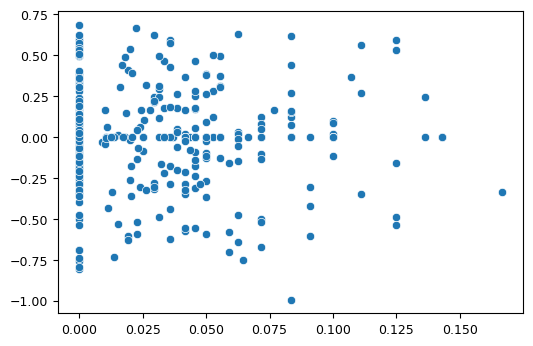

In [95]:
a, b, c = friend_analysis(reddit_ids,  reddit_adj, reddit_ops)

sns.scatterplot(b, c)

plt.show()

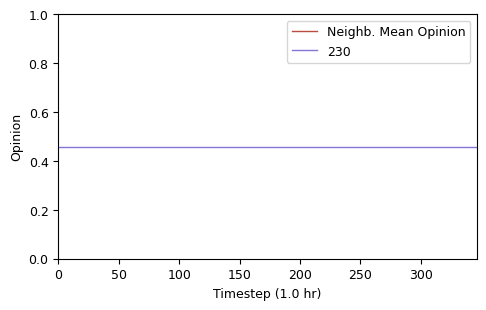

In [96]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

labels = get_friends(reddit_ids[230], reddit_edges)
data = [ reddit_ops[:, get_idx(reddit_ids, friend)] for friend in labels]
mean_data = means(np.transpose(data))


ax.plot(mean_data, linewidth=1.0, color=colors[0], label='Neighb. Mean Opinion')
ax.plot(reddit_ops[:, get_idx(reddit_ids,reddit_ids[230])], linewidth=1.0,color=colors[4], label='230')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep / 3600} hr)')
ax.set_ylabel('Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 3.10 Number of neighbours and correlation of opinion with neighbours

In [97]:
np.corrcoef(np.log(np.sum(reddit_adj, axis=1))[a], c)[0,1]

0.05931964417655499

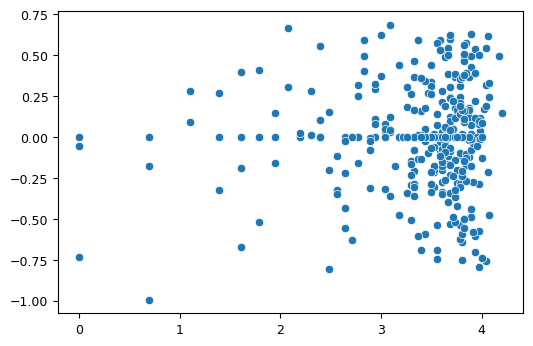

In [98]:
sns.scatterplot(np.log(np.sum(reddit_adj, axis=1))[a], c)

plt.show()

### 3.11 Difference in opinions with neighbours

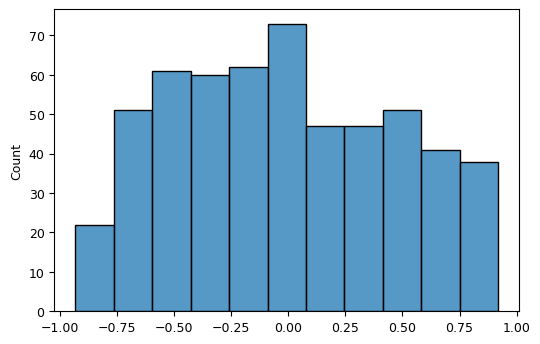

In [99]:
idx_data, diff_data = friend_diff_analysis(reddit_ids, reddit_adj, reddit_ops)
sns.histplot(diff_data)
plt.show()

In [100]:
idx_data[diff_data.index(min(diff_data))]

250

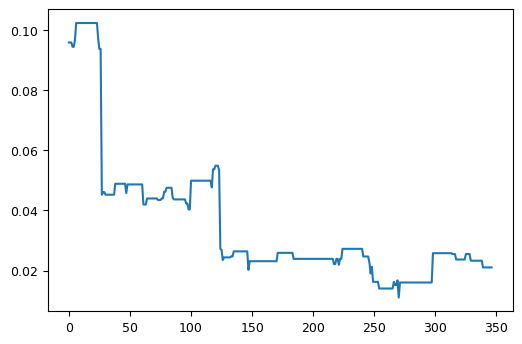

In [101]:
labels = get_friends(reddit_ids[216], reddit_edges)
data = [ reddit_ops[:, get_idx(reddit_ids, friend)] for friend in labels]
id_data = reddit_ops[:, 216]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), np.abs(np.array(mean_data) - id_data))
plt.show()

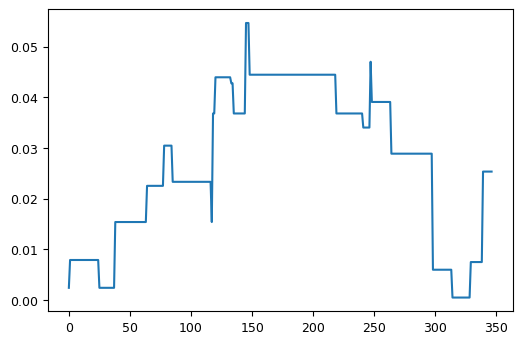

In [102]:
labels = get_friends(reddit_ids[538], reddit_edges)
data = [ reddit_ops[:, get_idx(reddit_ids, friend)] for friend in labels]
id_data = reddit_ops[:, 538]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), np.abs(np.array(mean_data) - id_data))
plt.show()

### 3.12 Correlation of decisions with neighbours

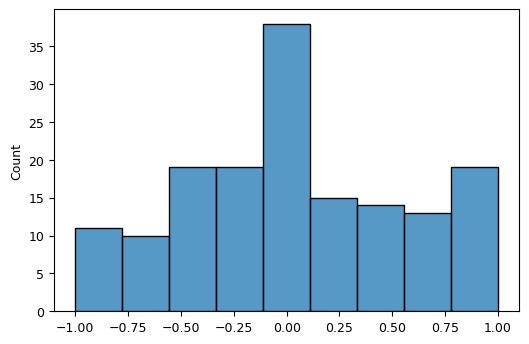

In [103]:
idx_data, dec_data = friend_dec_analysis(reddit_ids, reddit_adj, reddit_ops)
sns.histplot(dec_data)
plt.show()

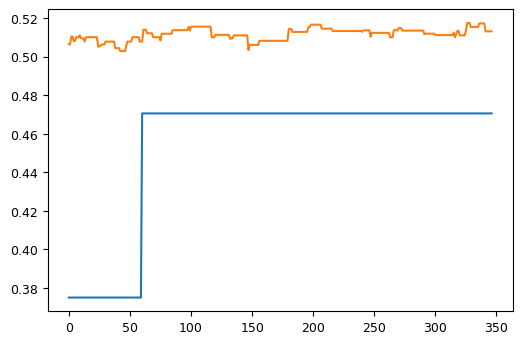

In [104]:
labels = get_friends(reddit_ids[396], reddit_edges)
data = [ reddit_ops[:, get_idx(reddit_ids, friend)] for friend in labels]
id_data = reddit_ops[:, 396]
mean_data = means(np.transpose(data))

sns.lineplot(range(len(id_data)), id_data)
sns.lineplot(range(len(id_data)), mean_data)
plt.show()